In [1]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx
import networkx as nx

from util_heterogeneous import *
from src.shared.database_wrapper import DatabaseWrapper
from src.shared.graph_sampling import GraphSampling

In [2]:
def neo_to_pyg_hetero_edges(
        data,
        node_attr: str
):
    if not data:
        return None, None

    nodes = data["nodes"]
    relationships = data["relationships"]

    # Create a PyG Data object
    pyg_data = CentralGraphData()

    node_features = []
    node_ids = []
    node_id_map = {}

    for node in nodes:
        node_id = node.get("id")
        node_feature = node.get(node_attr, None)
        if node_feature is None:
            print(f"Node {node_id} has no attribute {node_attr}")
            continue

        # Map node id to its index in the list
        idx = len(node_ids)
        node_id_map[node_id] = idx
        node_ids.append(node_id)

        # Convert node features to tensors
        node_feature_tensor = torch.tensor(node_feature, dtype=torch.float32)
        node_features.append(node_feature_tensor)

    # Convert list of features to tensor
    if node_features:
        pyg_data[NodeType.PUBLICATION.value].x = torch.vstack(node_features)
        pyg_data[NodeType.PUBLICATION.value].num_nodes = pyg_data[NodeType.PUBLICATION.value].x.size(0)
    else:
        print("No node features available.")
        return None, None

    # Process relationships
    edge_dict = {}

    for rel in relationships:
        key = edge_val_to_pyg_key_vals[rel.type]
        if key not in edge_dict:
            edge_dict[key] = [[], []]

        source_id = rel.start_node.get("id")
        target_id = rel.end_node.get("id")

        # Append the indices of the source and target nodes
        edge_dict[key][0].append(node_id_map[source_id])
        edge_dict[key][1].append(node_id_map[target_id])

    # Convert edge lists to tensors
    for key in edge_dict:
        pyg_data[key[0], key[1], key[2]].edge_index = torch.vstack([
            torch.tensor(edge_dict[key][0], dtype=torch.long),
            torch.tensor(edge_dict[key][1], dtype=torch.long)
        ])

        pyg_data[key[0], key[1], key[2]].edge_attr = torch.vstack(
            [edge_one_hot[key[1]] for _ in range(len(edge_dict[key][0]))])

    return pyg_data, node_id_map

In [3]:
def neo_to_pyg_homogeneous(
        data,
        node_attr: str,
):
    if not data:
        return None, None

    nodes = data["nodes"]
    relationships = data["relationships"]

    #print(f"Nodes: {len(nodes)}, Relationships: {len(relationships)}")

    # Create a PyG Data object
    pyg_data = CentralGraphData()

    node_features = []
    node_ids = []
    node_id_map = {}

    for node in nodes:
        node_id = node.get("id")
        node_feature = node.get(node_attr, None)
        if node_feature is None:
            print(f"Node {node_id} has no attribute {node_attr}")
            continue

        # Map node id to its index in the list
        idx = len(node_ids)
        node_id_map[node_id] = idx
        node_ids.append(node_id)

        # Convert node features to tensors
        node_feature_tensor = torch.tensor(node_feature, dtype=torch.float32)
        node_features.append(node_feature_tensor)

    # Convert list of features to tensor
    pyg_data.x = torch.vstack(node_features)
    pyg_data.num_nodes = pyg_data.x.size(0)

    # Process relationships
    edge_index_list = [[], []]

    for rel in relationships:
        source_id = rel.start_node.get("id")
        target_id = rel.end_node.get("id")

        if source_id not in node_id_map or target_id not in node_id_map:
            print(f"Edge from {source_id} to {target_id} cannot be mapped to node indices.")
            continue

        source_idx = node_id_map[source_id]
        target_idx = node_id_map[target_id]

        edge_index_list[0].append(source_idx)
        edge_index_list[1].append(target_idx)

    # Convert edge lists to tensor
    edge_index = torch.tensor(edge_index_list, dtype=torch.long)
    pyg_data.edge_index = edge_index

    return pyg_data, node_id_map

In [4]:
def plot_neo4j_hetero_graph(gs: GraphSampling, node_id: str):
    graph = gs.n_hop_neighbourhood(
        start_node_type=NodeType.PUBLICATION,
        start_node_id=node_id,
        max_level=2
    )
    hetero_data = neo_to_pyg_hetero_edges(graph, 'feature_vec')[0]
    
    nx_graph = to_networkx(hetero_data)
    
    plt.figure(figsize=(8, 8))
    nx.draw(nx_graph, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
    plt.show()
    
def plot_neo4j_homo_graphs(gs: GraphSampling, node_id: str, edge_type: EdgeType):
    print("Old graph sampling technique: ")
    graph = gs.expand_config_homogeneous(
        start_node_type=NodeType.PUBLICATION,
        start_node_id=node_id,
        edge_type=edge_type,
        max_level=2,
    )
    #print(graph)
    #print(graph["relationships"])
    G = nx.DiGraph()
    for node in graph["nodes"]:
        print(node['id'])
        if not node['id'] in G.nodes.keys():
            G.add_node(node['id'])
    for rel in graph["relationships"]:
        source_id = rel.start_node.get("id")
        target_id = rel.end_node.get("id")
        G.add_edge(source_id, target_id)
        print(rel.type)
    data = neo_to_pyg_homogeneous(graph, 'feature_vec')[0]
    print(data)
    print(data.edge_index)
    nx_graph = to_networkx(data)
    print(nx_graph)
    plt.figure(figsize=(8, 8))
    plt.title(f"{edge_type.value}")
    nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
    plt.show()
    plt.close()

def plot_neo4j_homo_graphs_new(gs: GraphSampling, node_id: str, edge_type: EdgeType):
    print("New graph sampling technique: ")
    graph = gs.n_hop_neighbourhood_homogeneous(
        start_node_type=NodeType.PUBLICATION,
        start_node_id=node_id,
        edge_type=edge_type,
        max_level=2,
    )
    #print(graph)
    #print(graph["relationships"])
    G = nx.DiGraph()
    for node in graph["nodes"]:
        print(node['id'])
        if not node['id'] in G.nodes.keys():
            G.add_node(node['id'])
    for rel in graph["relationships"]:
        source_id = rel.start_node.get("id")
        target_id = rel.end_node.get("id")
        G.add_edge(source_id, target_id)
        print(rel.type)
    data = neo_to_pyg_homogeneous(graph, 'feature_vec')[0]
    print(data)
    print(data.edge_index)
    nx_graph = to_networkx(data)
    print(nx_graph)
    plt.figure(figsize=(8, 8))
    plt.title(f"{edge_type.value}")
    nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
    plt.show()
    plt.close()

In [5]:
node_properties = [
    'id',
    'feature_vec',
]

node_spec = [
    NodeType.PUBLICATION
]

edge_spec = [
    #EdgeType.SIM_ABSTRACT,
    EdgeType.SIM_TITLE,
    #EdgeType.SIM_AUTHOR,
    #EdgeType.SAME_AUTHOR,
]

#db = DatabaseWrapper(database="homogeneous-graph")
gs = GraphSampling(
    database="homogeneous-graph",
    node_properties=node_properties,
    node_spec=node_spec,
    edge_spec=edge_spec
)

Using default edge type: SimilarTitle for homogeneous graph sampling.


Old graph sampling technique: 
yqRSYXq0
hU7YMYKm
MfZDaQCL
SimilarTitle
SimilarTitle
SimilarTitle
SimilarTitle
SimilarTitle
SimilarTitle
CentralGraphData(
  x=[3, 768],
  num_nodes=3,
  edge_index=[2, 6]
)
tensor([[1, 2, 2, 0, 0, 1],
        [0, 0, 1, 1, 2, 2]])
DiGraph with 0 nodes and 0 edges


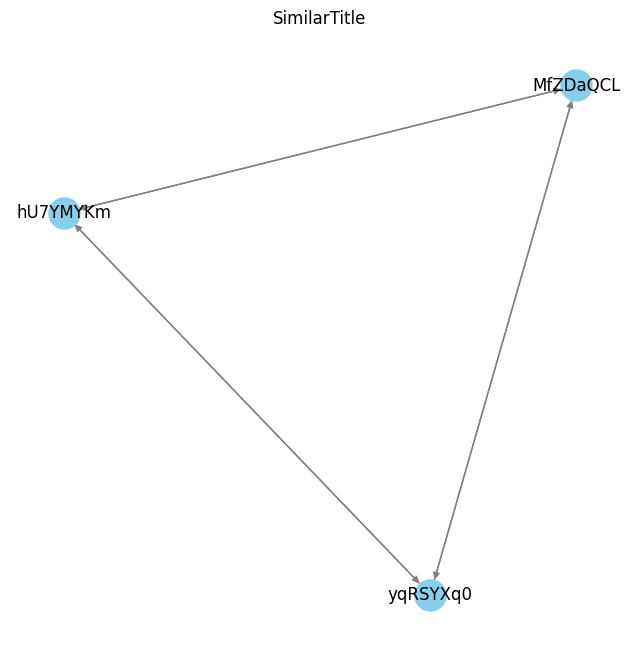

New graph sampling technique: 
yqRSYXq0
hU7YMYKm
MfZDaQCL
SimilarTitle
SimilarTitle
SimilarTitle
SimilarTitle
SimilarAuthor
SimilarTitle
SimilarTitle
CentralGraphData(
  x=[3, 768],
  num_nodes=3,
  edge_index=[2, 7]
)
tensor([[0, 0, 1, 1, 1, 2, 2],
        [2, 1, 0, 2, 0, 1, 0]])
DiGraph with 0 nodes and 0 edges


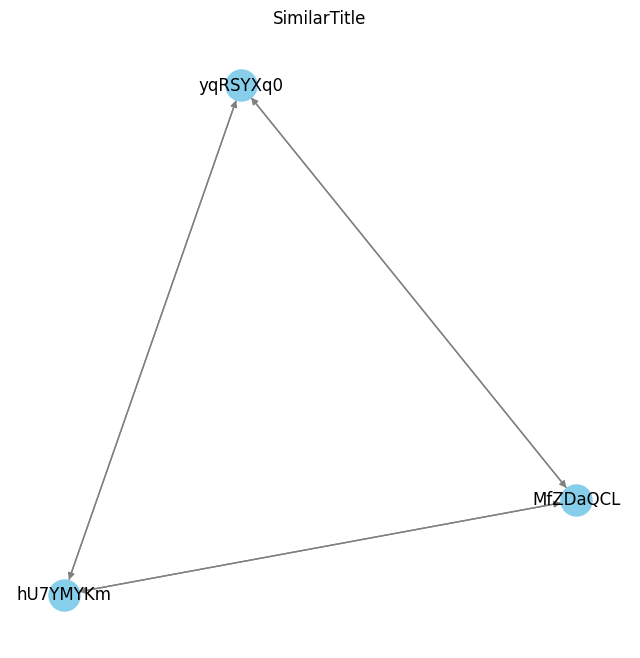

In [6]:
test_node_id = 'yqRSYXq0'
#plot_neo4j_hetero_graph(gs, test_node_id)
for edge in edge_spec:
    plot_neo4j_homo_graphs(gs, test_node_id, edge)
    plot_neo4j_homo_graphs_new(gs, test_node_id, edge)